In [1]:
#------------------------Package Loading----------------------------------#
import numpy as np 
from xarray import open_dataset as XOD
from xarray import DataArray as XDA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import nc_time_axis
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.ticker as mticker
from global_land_mask import globe
import pickle
R = 6378137 #radius of the earth in meters
#-------------------------------------------------------------------------#


#------------------------Function Defintion-------------------------------#
def add_latlon_ticks(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,30))
    
def find_nearest(array, value):
    array = np.asarray(array)
    best_option = (np.abs(array - value)).argmin()
    return array[best_option]

def put_on_grid(lat_in, lon_in, xp, yp):
    ltt = int(np.where(lat_in == find_nearest(lat_in, yp))[0][0])
    lnn = int(np.where(lon_in == find_nearest(lon_in, xp))[0][0])
    chh = R*np.sin((90-abs(ypos))*np.pi/180)
    return ([ltt,lnn,chh])

def temp_interpolate(currentv,nextv,step,numsteps):
    out = (currentv*(numsteps-step)+nextv*(step))/numsteps
    return out
#-------------------------------------------------------------------------#


In [2]:
#----------------------------User Inputs------------------------------------#

method = 'Rk4' # Rk4 Linear
start_lat = [10]  #for Passivley Affected Point TC-Proxies
start_lon = [240]
trial_start = 1
trial_stop = 1
Print_Output = False
Diagnostic_Output = True
temp_resolution = 1
#enter 1 for 1hr, 60 for 1min, 3600 for 1s, etc --computational expense scales linearly

#------------------------(Not Usually Changed)------------------------------#

mod_yr_month = '0004-08'
basefile = '/n/holyscratch01/keith_lab_seas/acrawford/geomod/data/Run/archive/'
data_out_file= '/n/home06/acrawford/mcb_data/sst_files/'
run_id = 'v2_'
day_i = 1
timestep_i = 3600
lev_s = 14 #14 (197.9mb)
lev_f = 25 #25 (859.5mb)

#--------------------------------------------------------------------------#

print('Advection Scheme Progress:\n')
all_tracks = []

#Determine Atmospheric Mass Fractionation
mass_file = XOD(basefile+run_id+'512'+'/atm/hist/'+'v2_512.cam.h0.0004-08-01-03600.nc')
mass_file = XDA.mean(mass_file['MASS'].isel(lev=np.arange(lev_s,lev_f+1,1),time=0),dim=['lat','lon'])
mass_sum = XDA.sum(mass_file,dim='lev').values

if Diagnostic_Output == True: method = 'Rk4'

#Iterate Through All Cases in Study
for case in range(trial_start,trial_stop+1):
    
    #Load Time-Discretized Wind Data
    midfile = basefile+run_id+'{0:03d}/atm/hist/'.format(case)
    infile = midfile+run_id+'{0:03d}.cam.h0.{1}-{2:02d}-{3:05d}.nc'\
        .format(case,mod_yr_month,day_i,timestep_i)
    xrdata = XOD(infile)
    
    #Establish Latitude, Longitude and Time Resolution Grids
    scale_factor = 3600/temp_resolution
    lat = xrdata['lat'].values
    lon = xrdata['lon'].values
    
    #Prepare Passivley Affected Point Starting Coordinates
    start_lat.sort()
    start_lon.sort()
    start_points = []
    for slat in start_lat: 
        for slon in start_lon: start_points.append([slat,slon])

    point_count = 0
    tc_master = []
    
    #Iterate Through All Points
    for point in start_points:
        
        #Pull Intial U, V Wind Vector Componentes and Apply Atmospheric Mass Weighting
        u_vals = XDA.sum((xrdata['U'].isel(lev=np.arange(lev_s,lev_f+1,1))*mass_file),dim='lev')/mass_sum
        v_vals = XDA.sum((xrdata['V'].isel(lev=np.arange(lev_s,lev_f+1,1))*mass_file),dim='lev')/mass_sum
        
        #Prepare Data Structs for Advection Iteration
        ypos = point[0]
        xpos = point[1]
        trial_step = case
        tc_hist =[[0,float(ypos),float(xpos)]]
        diag_hist=[]
        diag_hist2=[]
        diag_hist3=[]
        time_checkers = [timestep_i,0,1,0] #timestep, filetime, filedays, filecount
        
        #Time-Iterate Through Datafiles
        for time_master in range(1,14*24+1):

            if time_checkers[1] == 30:
                time_checkers[0] += 21600
                time_checkers[1] = 0
                time_checkers[2] += 1
                time_checkers[3] += 1

                try:
                    temp_data = XOD(midfile+run_id+'{0:03d}.cam.h0.{1}-{2:02d}-{3:05d}.nc'\
                                    .format(trial_step,mod_yr_month,time_checkers[2],time_checkers[0]))
                except FileNotFoundError:
                    time_checkers[0] = timestep_i
                    time_checkers[2] += 1
                    temp_data = XOD(midfile+run_id+'{0:03d}.cam.h0.{1}-{2:02d}-{3:05d}.nc'\
                                    .format(trial_step,mod_yr_month,time_checkers[2],time_checkers[0]))
                finally:
                    u_vals = XDA.sum((temp_data['U'].isel(lev=np.arange(lev_s,lev_f+1,1))*mass_file),dim='lev')/mass_sum
                    v_vals = XDA.sum((temp_data['V'].isel(lev=np.arange(lev_s,lev_f+1,1))*mass_file),dim='lev')/mass_sum

            #Load U, V Vectors for Given Timestep
            ucurrent = u_vals.isel(time=time_checkers[1]).values
            vcurrent = v_vals.isel(time=time_checkers[1]).values
            time_checkers[1] += 1
            
            #Exit Loop on First Iteration
            if time_master == 1: 
                uprev = ucurrent
                vprev = vcurrent
                continue
            
            #Interpolate Between CESM Time Gridpoints for Fine Time Resolution
            for increment in range(temp_resolution):
                ustep = temp_interpolate(uprev,ucurrent,increment,temp_resolution)
                vstep = temp_interpolate(vprev,vcurrent,increment,temp_resolution)
                ustepf = temp_interpolate(uprev,ucurrent,increment+1,temp_resolution)
                vstepf = temp_interpolate(vprev,vcurrent,increment+1,temp_resolution)
                ustep_av = 0.5*(ustep+ustepf)
                vstep_av = 0.5*(vstep+vstepf)
                
                #Perform Advection Based on Given Scheme
                lt = int(np.where(lat == find_nearest(lat, ypos))[0][0])
                ln = int(np.where(lon == find_nearest(lon, xpos))[0][0])
                chord = R*np.sin((90-abs(ypos))*np.pi/180)
                    
                if method == 'Rk4':
                    
                    k1y = vstep[lt,ln]*(scale_factor*180)/(R*np.pi)
                    k1x = ustep[lt,ln]*(scale_factor*180)/(chord*np.pi)
                    lt1 = int(np.where(lat == find_nearest(lat, ypos+k1y/2))[0][0])
                    ln1 = int(np.where(lon == find_nearest(lon, xpos+k1x/2))[0][0])
                    chord1 = R*np.sin((90-abs(ypos+k1y/2))*np.pi/180)
                    
                    k2y = vstep_av[lt1,ln1]*(scale_factor*180)/(R*np.pi)
                    k2x = ustep_av[lt1,ln1]*(scale_factor*180)/(chord1*np.pi)
                    lt2 = int(np.where(lat == find_nearest(lat, ypos+k2y/2))[0][0])
                    ln2 = int(np.where(lon == find_nearest(lon, xpos+k2x/2))[0][0])
                    chord2 = R*np.sin((90-abs(ypos+k2y/2))*np.pi/180)
                    
                    k3y = vstep_av[lt2,ln2]*(scale_factor*180)/(R*np.pi)
                    k3x = ustep_av[lt2,ln2]*(scale_factor*180)/(chord2*np.pi)
                    lt3 = int(np.where(lat == find_nearest(lat, ypos+k3y))[0][0])
                    ln3 = int(np.where(lon == find_nearest(lon, xpos+k3x))[0][0])
                    chord3 = R*np.sin((90-abs(ypos+k3y))*np.pi/180)
                    
                    k4y = vstepf[lt3,ln3]*(scale_factor*180)/(R*np.pi)
                    k4x = ustepf[lt3,ln3]*(scale_factor*180)/(chord3*np.pi)
                    
                    ypos += k1y/6 + k2y/3 + k3y/3 + k4y/6
                    xpos += k1x/6 + k2x/3 + k3x/3 + k4x/6
                    
                elif method == 'Linear':
                    
                    ypos += vstep[lt,ln]*(scale_factor*180)/(R*np.pi)
                    xpos += ustep[lt,ln]*(scale_factor*180)/(chord*np.pi)
                
                else:
                    raise KeyError('Acceptable Advection Methods: [Linear, RK4]')
                
                #Save Interim Data for Error Checking Analysis
                if Diagnostic_Output == True:
                    diag_hist.append([time_master+(increment/temp_resolution),
                                (k1y/6 + k2y/3 + k3y/3 + k4y/6),
                                (k1x/6 + k2x/3 + k3x/3 + k4x/6),vcurrent[lt,ln]])
                    diag_hist2.append([time_master+(increment/temp_resolution),
                                float(vstep[lt,ln]*(scale_factor*180)/(R*np.pi)),
                                float(ustep[lt,ln]*(scale_factor*180)/(chord*np.pi)),vstep[lt,ln]])
                    diag_hist3.append([k1y/6,k2y/3,k3y/3,k4y/6,k1x/6,k2x/3,k3x/3,k4x/6,chord])
            
            #Store Final Vector Magnitudes for Next Step in Iteration
            uprev = ucurrent
            vprev = vcurrent
            
            tc_hist.append([time_master,float(ypos),float(xpos)])
            
            #Print Each Advection Step
            if Print_Output == True:
                print ('Point: {3}  |  hour: {0}  |  lat: {1}  |  lon: {2}'
                       .format(time_master,vstep[lt,ln]*(60**2*180)/(R*np.pi),
                              ustep[lt,ln]*(60**2*180)/(chord*np.pi),point_count+1))
                
        tc_master.append(tc_hist)
        point_count += 1
        
    #Store All TC Tracks    
    all_tracks.append(tc_master)
    print('   Case {0} ({1}/{2}): ADVECTED'.format(case,case-trial_start+1,trial_stop-trial_start+1))

#Write Data for ATSA Routine
with open(data_out_file+'model_2c_advection_data.txt','wb') as file:
    pickle.dump(all_tracks,file)
with open(data_out_file+'model_2c_advection_start.txt','wb') as file:
    pickle.dump(trial_start,file)

print('\nAdvection Finished.')


Advection Scheme Progress:

   Case 1 (1/1): ADVECTED

Advection Finished.


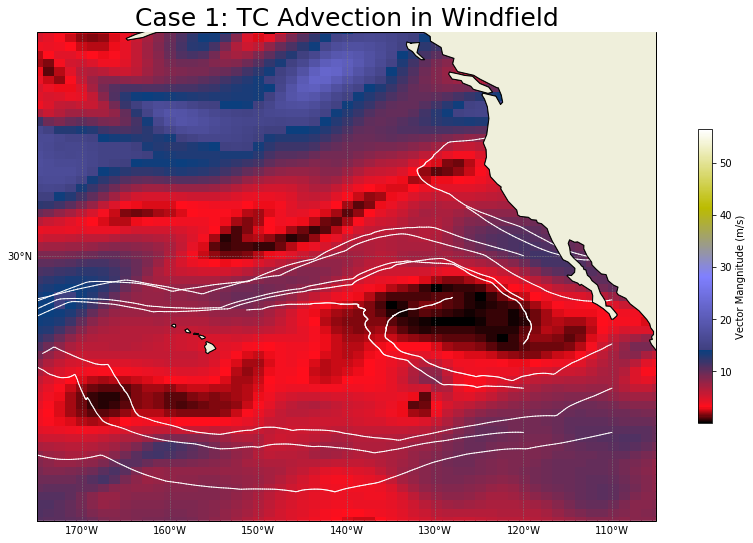

In [11]:
## Visualization Routine ##

#Calculate Wind Magnitude Grid
w_mag = (ucurrent**2+vcurrent**2)**0.5

#Build Figure and Background Grids for Mapping
lon_b = np.linspace(0, 360, 288)
lat_b = np.linspace(-90, 90,192)
fig = plt.figure(figsize=[15,9])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cft.LAND, zorder=100, edgecolor='k')
ax.coastlines()
add_latlon_ticks(ax)

#Add TC Adevection Tracks
for track in range(len(tc_master)):
    tc_hist = tc_master[track][:]
    if track%2==0: c='white'
    else: c='white'
    for step in range(len(tc_hist)-1):
        plt.plot([tc_hist[step][2],tc_hist[step+1][2]],[tc_hist[step][1],tc_hist[step+1][1]], 
                 color = c, linewidth=1, transform=ccrs.PlateCarree())
        
#Add Color and Title
plt.pcolormesh(lon_b, lat_b, w_mag, cmap='gist_stern')
plt.title('Case {0}: TC Advection in Windfield'.format(trial_stop), fontsize=25)
cb = plt.colorbar(shrink=0.6)
cb.set_label("Vector Mangnitude (m/s)")
ax.set_extent([185, 255, 0,50])

plt.show()


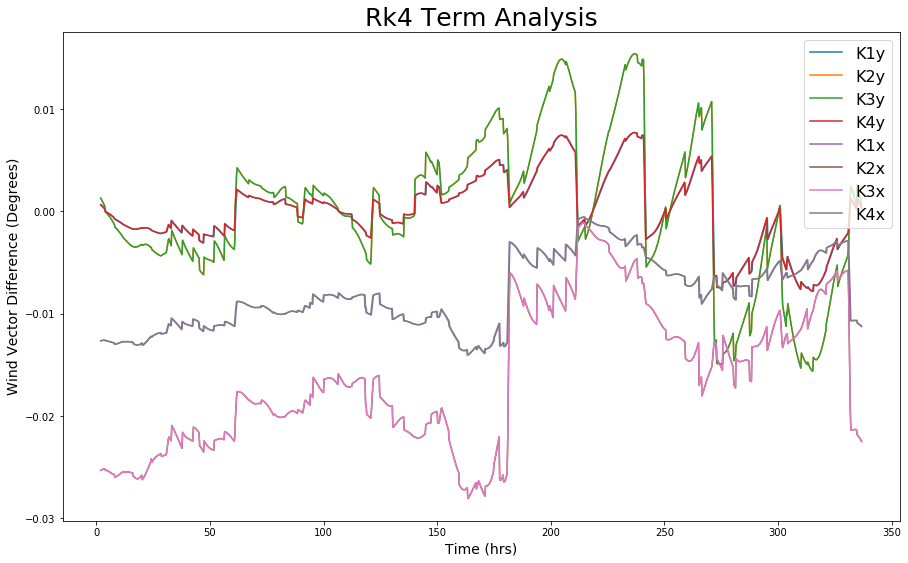

In [13]:
## Diagnositics Routine --- For Error Checking ##

#-----------------------------User Input----------------------------------#

Analyze_Interpolation = False
Analyze_Advection = False
RK4_Term_Analysis = True
ky_on = True
kx_on = True
chord_map = False
restrict_time_region = False
restriction_region = [205,215]

#-------------------------------------------------------------------------#

if Diagnostic_Output == True:
    
    if Analyze_Interpolation == True and Analyze_Advection == True:
        raise KeyError('Please Analyze Only Interpolation or Advection Scheme')
    
    fig = plt.figure(figsize=[15,9])
    time=[]
    y1=[]
    y2=[]
    y3=[]
    y12=[]
    y22=[]
    y32=[]
    for elem in diag_hist:
        time.append(elem[0])
        y1.append(elem[1])
        y2.append(elem[2])
        y3.append(elem[3])
    for elem in diag_hist2:
        y12.append(elem[1])
        y22.append(elem[2])
        y32.append(elem[3])
    sum1 = (np.mean(list(map(abs,y1)))+np.mean(list(map(abs,y12))))/2
    sum2 = (np.mean(list(map(abs,y2)))+np.mean(list(map(abs,y22))))/2
    if RK4_Term_Analysis == True:
        if Analyze_Interpolation == True or Analyze_Advection == True:
            raise KeyError('Please Analyze Only Rk4 Terms')
        k1ys = []
        k2ys = []
        k3ys = []
        k4ys = []
        k1xs = []
        k2xs = []
        k3xs = []
        k4xs = []
        chords = []
        for elem in diag_hist3:
            k1ys.append(elem[0])
            k2ys.append(elem[1])
            k3ys.append(elem[2])
            k4ys.append(elem[3])
            k1xs.append(elem[4])
            k2xs.append(elem[5])
            k3xs.append(elem[6])
            k4xs.append(elem[7])
            chords.append(elem[8])
        if ky_on == True:
            plt.plot(time,k1ys,Label='K1y')
            plt.plot(time,k2ys,Label='K2y')
            plt.plot(time,k3ys,Label='K3y')
            plt.plot(time,k4ys,Label='K4y')
        if kx_on == True:
            plt.plot(time,k1xs,Label='K1x')
            plt.plot(time,k2xs,Label='K2x')
            plt.plot(time,k3xs,Label='K3x')
            plt.plot(time,k4xs,Label='K4x')
        if chord_map == True:
            fig.clf()
            plt.axhline(R,color='black')
            plt.plot(time,chords,Label='Chord Values (m)')
        plt.title('Rk4 Term Analysis', fontsize=25)
        plt.ylabel('Wind Vector Difference (Degrees)',fontsize=14)
           
    elif Analyze_Interpolation == True:
        plt.plot(time,np.divide(y3,1),Label='V Stepping')
        plt.plot(time,y32,Label='V Interpolated')
        plt.title('Interpolation Analysis: Convergence Expected (V Velocity)', fontsize=25)
        plt.ylabel('Wind Vector Magnitude (m/s)',fontsize=14)
    elif Analyze_Advection == True:
        print('\nRMSE(V) = {0:.3f}%'.format(np.mean(list(map(abs,np.divide(np.subtract(y1,y12),sum1)*100)))))
        print('RMSE(U) = {0:.3f}%\n'.format(np.mean(list(map(abs,np.divide(np.subtract(y2,y22),sum2)*100)))))
        plt.plot(time,np.divide(np.subtract(y1,y12),sum1)*100,Label='V Velocity Difference')
        plt.plot(time,np.divide(np.subtract(y2,y22),sum2)*100,Label='U Velocity Difference')
        plt.title('Advection Analysis: Difference Between RK4 and Linear Scheme', fontsize=25)
        plt.ylabel('Advection Scheme Difference (%)',fontsize=14)
        plt.ylim([-100,100])
        plt.axhline(0,color='black')
    else:
        raise KeyError('Please Select a Scheme to Analyze [Interpolation, Advection]')
    plt.legend(fontsize=16)
    plt.xlabel('Time (hrs)',fontsize=14)
    
    if restrict_time_region == True:
        plt.xlim(restriction_region)
        
else:
    print('Diagnostic Output Must be set to [True] in Advection Scheme')
    